# Airspeed Calibration Analysis of June 15th 2022 CREATeV Flight
For reference to development see 2023-08-12_AirspeedCalibrationPost_June15_2022.ipynb

## Setting up 

In [46]:
# Creating filepaths, data paths
name = '2023-09-07_AirspeedCalibrationPost_June15_2022'
data_path = '../data/'
data_folder = 'createv-2022-06-15'
file_name = 'june15_2022.BIN'
datasave_path = data_path+data_folder+'/'
result_path = '../Results/'+name+'/'
figure_path = '../Figures/'+name+'/'

In [47]:
# Getting packages #

from os import sys
import os
sys.path.append('../')

%matplotlib widget

from matplotlib import pyplot as plt
from matplotlib.widgets import SpanSelector
import numpy as np
import pandas as pd
from scipy import optimize 
from scipy.io import savemat
from scipy import odr
import pandas as pd
import decimal
import math

import plotly.express as px

import main
from main import flight
from main import analysis
import propellers
import motors
from aircraft import airplane
import cl_finders

import data_exporter
import datetime

### Creating Folders for Results/Data ###
if not os.path.exists(result_path):
    os.makedirs(result_path)
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

# Setting Plot Defaults
plt.style.use('../basic_plotter.mplstyle')

In [48]:
# Vehicle parameters
prop = propellers.aeronaut20x8() # Using aeronaut 20x8 for this flight
motor = motors.U7V2_280KV()  # Using U7 V2 motor

mass = 12.727 # Estimated with virtual bolt included
span = 6.28
chord = 0.395
createv = airplane(mass, chord, span)

P_systems = 4 # Amount of power consumed by everything except the ESC & motor

highorderpolar = True

In [49]:
# Importing data, specifying import characteristics, backing up results
rate = "10ms"
interpolateM = "linear"
processor = "CREATeV_2022"

rawdata_name = data_folder+'/'+file_name.split('.')[0]+'_'+rate+'_'+interpolateM+'_'+processor+'.pkl'

# Checking if the data is already pickled for analysis
if os.path.exists(data_path+rawdata_name):
    df = pd.read_pickle(data_path+rawdata_name)
else:
    df = main.get_data(processor, data_folder+'/'+file_name, rate)
    df = df.interpolate(method=interpolateM)
    pd.to_pickle(df, data_path+rawdata_name) # Storing parsed data

In [50]:
# Adding indices to the dataframe for plotting
df["index_ref"] = np.arange(0, df.shape[0])

In [51]:
# Initializing mapbox parameters

token = "pk.eyJ1Ijoid2tlbXA5NCIsImEiOiJjbGI0NHJuemkwMmF2M29zM24xcTlpNXVjIn0.qSiAc29MftNSOK2DOpRggw"
color_scale = [(0, 'orange'), (1,'red')]

In [52]:
# Function for span selection

def onselect_plotgroundtrack(xmin, xmax):
    xmin = decimal.Decimal(xmin)
    xmin = math.ceil(xmin)
    xmin = round(xmin)

    xmax = decimal.Decimal(xmax)
    xmax = math.floor(xmax)
    xmax = round(xmax)

    df_sample = df.iloc[xmin:xmax]

    fig2 = px.scatter_mapbox(df_sample, 
                        lat="Latitude", 
                        lon="Longitude", 
                        hover_name=df_sample.index, 
                        #hover_data=["Address", "Listed"],
                        color="Airspeed_Sensor0",
                        color_continuous_scale='jet',
                        #size="Listed",
                        zoom=15.5, 
                        height=600,
                        width=900,
                        labels={"Airspeed": 'Airspeed (m/s)'},
                        center={'lat':44.0427, 'lon':-79.845},
                        template='presentation')
    fig2.update_layout(mapbox_style="satellite", mapbox_accesstoken=token)
    fig2.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig2.show()

    # Try plotting time on the x axis, and overplotting index as the real axis.  
    # 1. Generate plot of airspeeds vs the absolute index
    # 2. Create a dummy series showing the time index

## Visualizing Complete Dataset of Airspeed

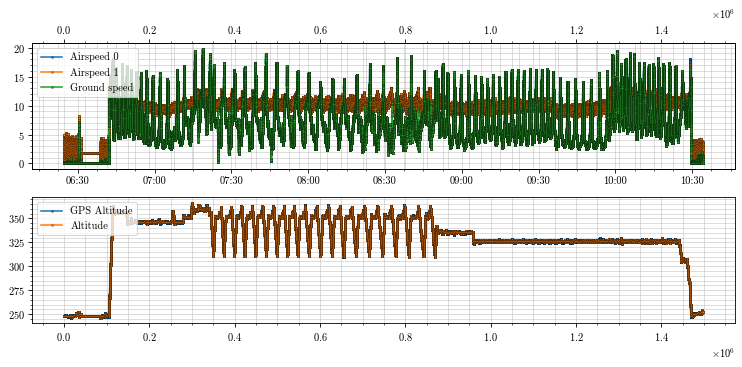

In [53]:
# Visuals of Speeds vs Time, and Altitudes vs Time

fig = plt.figure(figsize=(10,5), dpi=75)
ax1 = plt.subplot(2,1,1)
ax1.plot(df.index, df.Groundspeed_GPS)
ax2 = ax1.twiny()
ax2.plot(df.index_ref, df.Airspeed_Sensor0, label='Airspeed 0')
ax2.plot(df.index_ref, df.Airspeed_Sensor1, label='Airspeed 1')
ax2.plot(df.index_ref, df.Groundspeed_GPS, label='Ground speed')
ax2.legend(loc="upper left")

ax3 = plt.subplot(2, 1, 2, sharex=ax2)
ax3.plot(df.index_ref, df.Altitude_GPS, label='GPS Altitude')
ax3.plot(df.index_ref, df.Altitude, label='Altitude')
ax3.legend(loc="upper left")
plt.show()

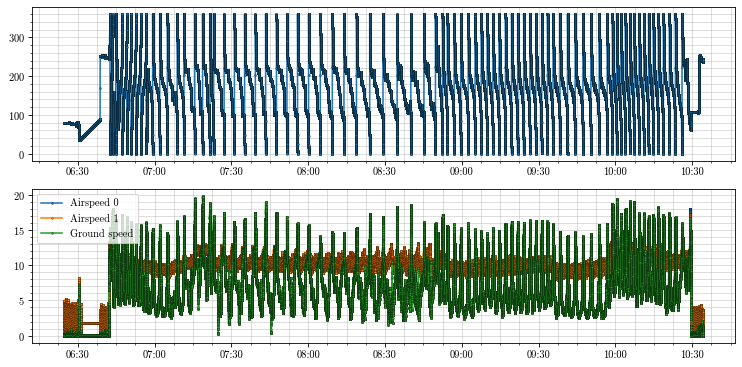

In [54]:
# Visuals of Heading vs Time, and Speeds vs Time
fig = plt.figure(figsize=(10,5), dpi=75)
ax1 = plt.subplot(2,1,1)
ax1.plot(df.index, df.Heading)

ax2 = plt.subplot(2,1,2, sharex=ax1)
ax2.plot(df.index, df.Airspeed_Sensor0, label='Airspeed 0')
ax2.plot(df.index, df.Airspeed_Sensor1, label='Airspeed 1')
ax2.plot(df.index, df.Groundspeed_GPS, label='Ground speed')
ax2.legend(loc='upper left')
plt.show()

## Separating into Loiters

In [55]:
# Using discontinuity of heading to separate into loiters

heading_array = df.Heading.to_numpy()
jump = np.diff(heading_array)
jump = np.abs(np.insert(jump, 0, -1, axis=0))

edge_mask = np.logical_and(jump >= 80, heading_array > 0.95 * 360)
loiter_times = loiter_mask.loc[edge_mask == True] # Loiter Series storing loiter number, start time, end time. 

In [80]:
# Function for separating time indexed data by loiter number, and calculating loiter position

def loiter_show(df, loiter_times, segment_test, show=True):
    mask = cl_finders.mask_fromTime(df, loiter_times.index[segment_test], loiter_times.index[segment_test+1])
    segment = df[mask]

    lattitude = np.array(segment.Latitude)
    longitude = np.array(segment.Longitude)

    y0 = (np.max(lattitude) + np.min(lattitude)) * 0.5
    x0 = (np.max(longitude) + np.min(longitude)) * 0.5

    # Finding theta angles
    x_diffs = longitude - x0
    y_diffs = lattitude - y0

    thetas = np.arctan2(y_diffs, x_diffs) * 180 / np.pi
    thetas = np.where(thetas < 0, thetas+360, thetas)
    jump = np.diff(thetas)
    jump = np.abs(np.insert(jump, 0, -1, axis=0))
    boolean_jump = jump > 10
    jump_index = int(np.where(boolean_jump)[0])
    thetas[jump_index:] = thetas[jump_index:] + 360

    if show:
        plt.figure()
        plt.plot(longitude, lattitude)
        plt.plot(x0, y0, marker='D')
        plt.plot(x0, np.max(lattitude), marker='D')
        plt.plot(x0, np.min(lattitude), marker='D')
        plt.plot(np.max(longitude), y0, marker='D')
        plt.plot(np.min(longitude), y0, marker='D')
        plt.show()

        plt.figure()
        plt.plot(thetas)
        plt.plot(jump)
        plt.show()

        plt.figure()
        plt.plot(thetas, segment.Groundspeed_GPS)
        plt.show()
    return thetas, segment

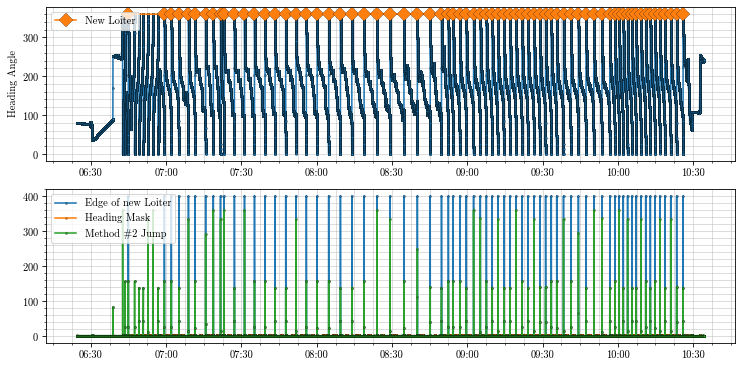

In [73]:
# Visualizing Loiter Separations
fig = plt.figure(figsize=(10,5), dpi=75)
ax1 = plt.subplot(2,1,1)
ax1.plot(df.index, df.Heading)
ax1.plot(df.index[edge_mask == True], df.Heading[edge_mask == True], marker='D', markersize=10, linestyle=None, label="New Loiter")
ax1.set_ylabel("Heading Angle")
ax1.legend(loc="upper left")

ax2 = plt.subplot(2,1,2, sharex=ax1)
ax2.plot(df.index, edge_mask*400, label='Edge of new Loiter')
ax2.plot(df.index, heading_mask, label="Heading Mask")
ax2.plot(df.index, jump, label="Method #2 Jump")
ax2.legend(loc='upper left')
plt.show()

In [91]:
# Function for collecting the consecutive results of several loiters, showing the speeds and groundtrack to ensure meets criteria!

def collect_loitersegments(loiter_numbers, loiter_times, show=False):
    theta_complete = np.array([])
    segments_complete = pd.DataFrame()

    for count, loiter_number in enumerate(loiter_numbers):
        [thetas, segment_df] = loiter_show(df, loiter_times, loiter_number, show=False)
        thetas = thetas + (count * 360) # Increasing the theta angle by 360 degrees for subsequent loiters
        theta_complete = np.concatenate((theta_complete, thetas), axis=0)
        segments_complete = pd.concat([segments_complete, segment_df])

    if show:
        fig = plt.figure()
        ax1 = plt.subplot(1,2,1)
        ax2 = plt.subplot(1,2,2)
        for i, loiter_number in enumerate(loiter_numbers):
            mask = cl_finders.mask_fromTime(df, loiter_times.index[loiter_number], loiter_times.index[loiter_number+1])
            segment = df[mask]
            ax1.plot(segment.Latitude, segment.Longitude, marker='', label="Loiter: " + str(loiter_number))
        ax1.set_xlabel("Lattitude")
        ax1.set_ylabel("Longitude")
        ax1.legend()

        ax2.plot(theta_complete, segments_complete.Groundspeed_GPS, label="Ground Speed")
        ax2.plot(theta_complete, segments_complete.Airspeed_Sensor0, label="Sensor 0 Airspeed")
        ax2.plot(theta_complete, segments_complete.Airspeed_Sensor1, label="Sensor 1 Airspeed")
        ax2.plot(theta_complete, np.ones(np.shape(theta_complete)) * np.mean(segments_complete.Airspeed_Sensor0), marker='', linestyle='-', label="Average Airspeed Sensor 0")
        ax2.plot(theta_complete, np.ones(np.shape(theta_complete)) * np.mean(segments_complete.Airspeed_Sensor1), marker='', linestyle='-', label="Average Airspeed Sensor 1")
        ax2.plot(theta_complete, segments_complete.Airspeed_Demanded, marker='', color='red', label="Demanded Airspeed")
        ax2.legend(loc="upper right")
        ax2.set_xlabel("Loiter Position (Degrees)")
        ax2.set_ylabel("Speed [m/s]")
        ax2.legend()
        
        plt.show()

    return theta_complete, segments_complete

## Collecting data from consecutive loiters
Looking for nice circular loiters with good constant airspeed.  

Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.


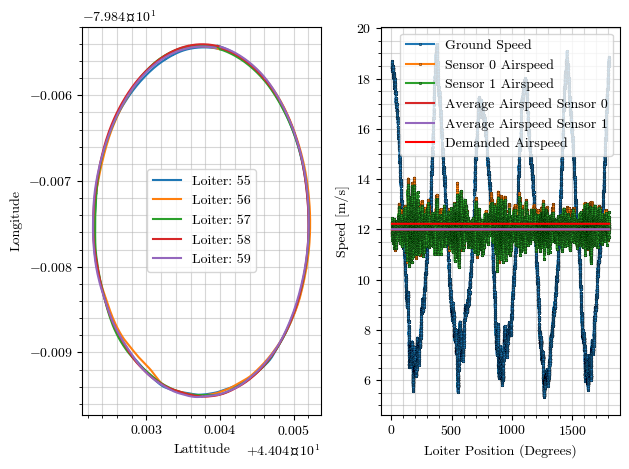

In [93]:
loiter_numbers = np.array([55, 56, 57, 58, 59])
theta_s1, df_s1 = collect_loitersegments(loiter_numbers, loiter_times, show=True)

In [60]:
# Curve fitting function for traditional fitting tools
    
def wind_model(theta, Vw_fit, Vinf_fit, phase_offset):
    # Note that theta is given in degrees!
    theta_rad = np.deg2rad(theta)
    Vg = Vinf_fit * np.sin(np.arccos((Vw_fit/Vinf_fit)*np.cos(theta_rad + phase_offset))) + Vw_fit*np.sin(theta_rad + phase_offset)
    return Vg

# Using the accumulated data from previous block to test the fitting abilities

Vg_actual = np.array(segments_complete.Groundspeed_GPS)
[pop_result, cov_result] = optimize.curve_fit(wind_model, theta_complete, Vg_actual, [5, 10, 0])

groundspeed_fit = wind_model(theta_complete, pop_result[0], pop_result[1], pop_result[2])
pop_result

array([ 5.52437315, 12.10648536,  1.14131878])

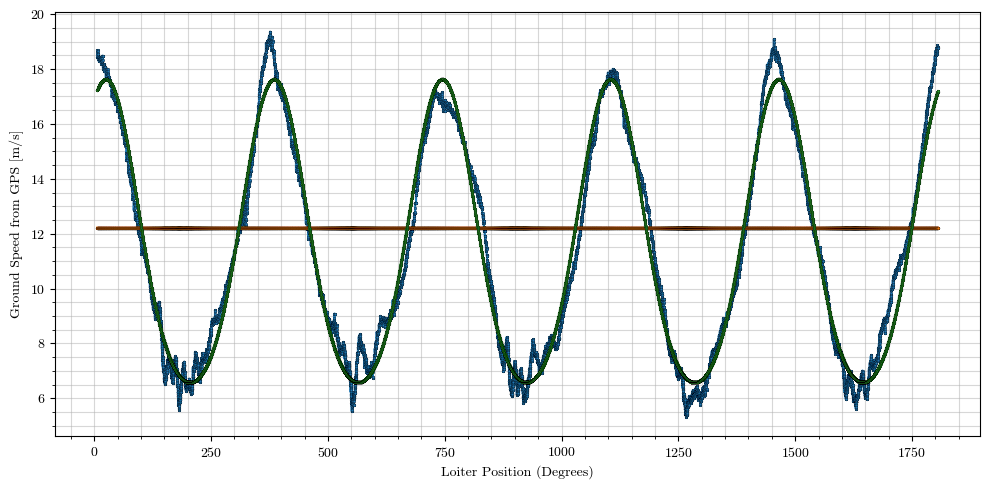

In [61]:
plt.figure(figsize=(10,5))
plt.plot(theta_complete, segments_complete.Groundspeed_GPS)
plt.plot(theta_complete, segments_complete.Airspeed_Demanded)
plt.plot(theta_complete, groundspeed_fit)
plt.xlabel("Loiter Position (Degrees)")
plt.ylabel("Ground Speed from GPS [m/s]")
plt.show()

11582
11116
11048
10957
11617


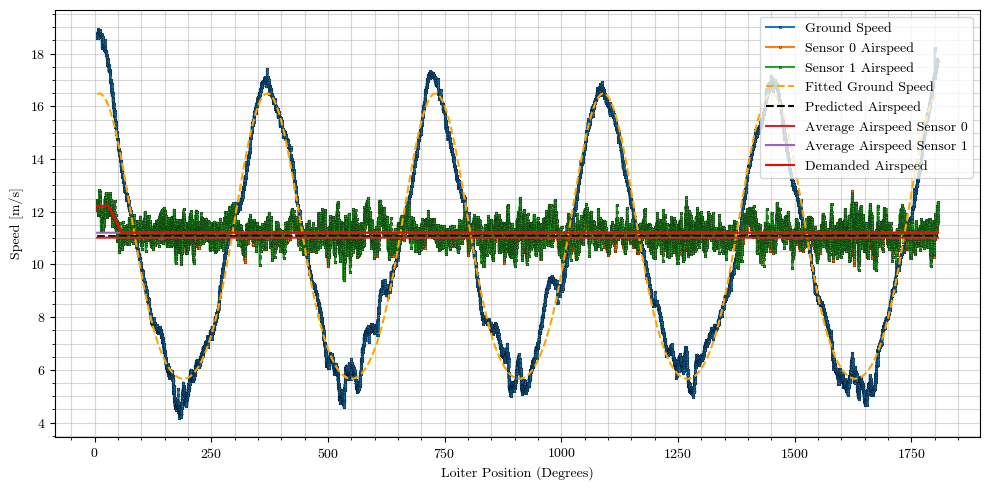

array([ 5.41225887, 11.07445341,  1.39173569])

In [62]:
theta_complete = np.array([])
segments_complete = pd.DataFrame()

for count, loiter_number in enumerate([60, 61, 62, 63, 64]):
    [thetas, segment_df] = loiter_show(df, loiter_times, loiter_number, show=False)
    thetas = thetas + (count * 360) # Increasing the theta angle by 360 degrees for subsequent loiters
    theta_complete = np.concatenate((theta_complete, thetas), axis=0)
    segments_complete = pd.concat([segments_complete, segment_df])

Vg_actual = np.array(segments_complete.Groundspeed_GPS)
[pop_result, cov_result] = optimize.curve_fit(wind_model, theta_complete, Vg_actual, [5, 10, 0])

groundspeed_fit = wind_model(theta_complete, pop_result[0], pop_result[1], pop_result[2])


plt.figure(figsize=(10,5))
plt.plot(theta_complete, segments_complete.Groundspeed_GPS, label="Ground Speed")
plt.plot(theta_complete, segments_complete.Airspeed_Sensor0, label="Sensor 0 Airspeed")
plt.plot(theta_complete, segments_complete.Airspeed_Sensor1, label="Sensor 1 Airspeed")
plt.plot(theta_complete, groundspeed_fit, marker='', linestyle='--', color='orange', label="Fitted Ground Speed")
plt.plot(theta_complete, np.ones(np.shape(theta_complete)) * pop_result[1], marker='', linestyle='--', color='black', label="Predicted Airspeed")
plt.plot(theta_complete, np.ones(np.shape(theta_complete)) * np.mean(segments_complete.Airspeed_Sensor0), marker='', linestyle='-', label="Average Airspeed Sensor 0")
plt.plot(theta_complete, np.ones(np.shape(theta_complete)) * np.mean(segments_complete.Airspeed_Sensor1), marker='', linestyle='-', label="Average Airspeed Sensor 1")

plt.plot(theta_complete, segments_complete.Airspeed_Demanded, marker='', color='red', label="Demanded Airspeed")

plt.legend(loc="upper right")
plt.xlabel("Loiter Position (Degrees)")
plt.ylabel("Speed [m/s]")
plt.show()
pop_result

13969
13999


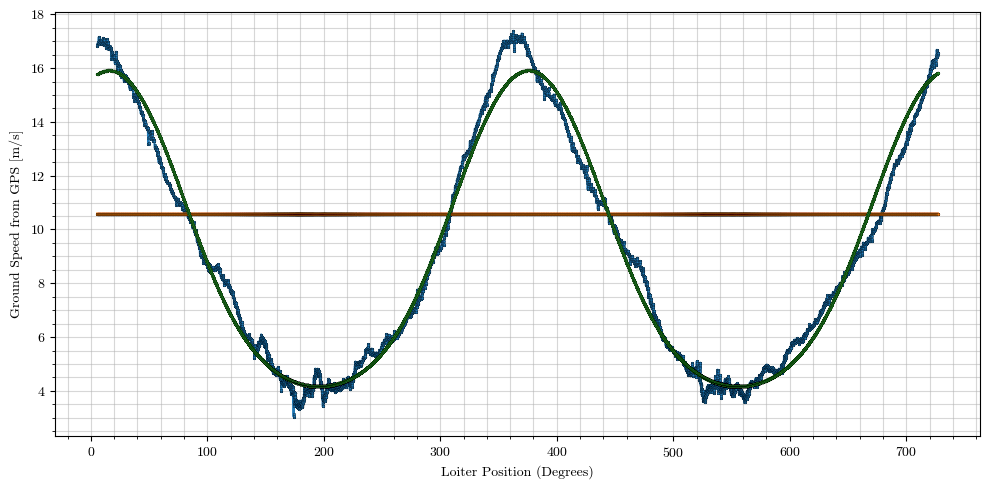

array([ 5.8705324 , 10.04389862,  1.29688246])

In [63]:
theta_complete = np.array([])
segments_complete = pd.DataFrame()

for count, loiter_number in enumerate([66, 67]):
    [thetas, segment_df] = loiter_show(df, loiter_times, loiter_number, show=False)
    thetas = thetas + (count * 360) # Increasing the theta angle by 360 degrees for subsequent loiters
    theta_complete = np.concatenate((theta_complete, thetas), axis=0)
    segments_complete = pd.concat([segments_complete, segment_df])

Vg_actual = np.array(segments_complete.Groundspeed_GPS)
[pop_result, cov_result] = optimize.curve_fit(wind_model, theta_complete, Vg_actual, [5, 10, 0])

groundspeed_fit = wind_model(theta_complete, pop_result[0], pop_result[1], pop_result[2])


plt.figure(figsize=(10,5))
plt.plot(theta_complete, segments_complete.Groundspeed_GPS)
plt.plot(theta_complete, segments_complete.Airspeed_Demanded)
plt.plot(theta_complete, groundspeed_fit)
plt.xlabel("Loiter Position (Degrees)")
plt.ylabel("Ground Speed from GPS [m/s]")
plt.show()
pop_result

16039
14416
13728
13278
14439
14728


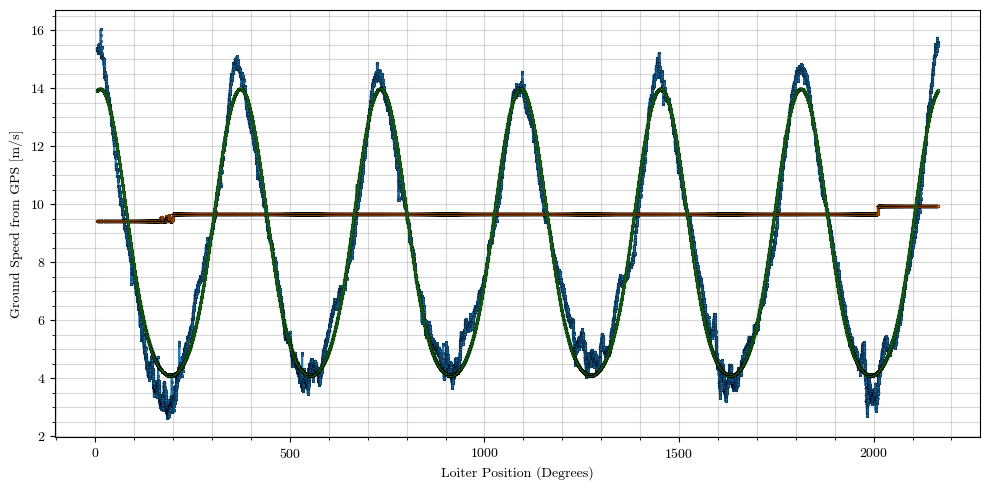

array([4.94561271, 9.04722046, 1.35244164])

In [64]:
theta_complete = np.array([])
segments_complete = pd.DataFrame()

list = np.arange(29,30)

for count, loiter_number in enumerate([33, 34, 35, 36, 37, 38]):
    [thetas, segment_df] = loiter_show(df, loiter_times, loiter_number, show=False)
    thetas = thetas + (count * 360) # Increasing the theta angle by 360 degrees for subsequent loiters
    theta_complete = np.concatenate((theta_complete, thetas), axis=0)
    segments_complete = pd.concat([segments_complete, segment_df])

Vg_actual = np.array(segments_complete.Groundspeed_GPS)
[pop_result, cov_result] = optimize.curve_fit(wind_model, theta_complete, Vg_actual, [5, 10, 0])

groundspeed_fit = wind_model(theta_complete, pop_result[0], pop_result[1], pop_result[2])


plt.figure(figsize=(10,5))
plt.plot(theta_complete, segments_complete.Groundspeed_GPS)
plt.plot(theta_complete, segments_complete.Airspeed_Demanded)
plt.plot(theta_complete, groundspeed_fit)
plt.xlabel("Loiter Position (Degrees)")
plt.ylabel("Ground Speed from GPS [m/s]")
plt.show()
pop_result

15758
15433
17292
16039


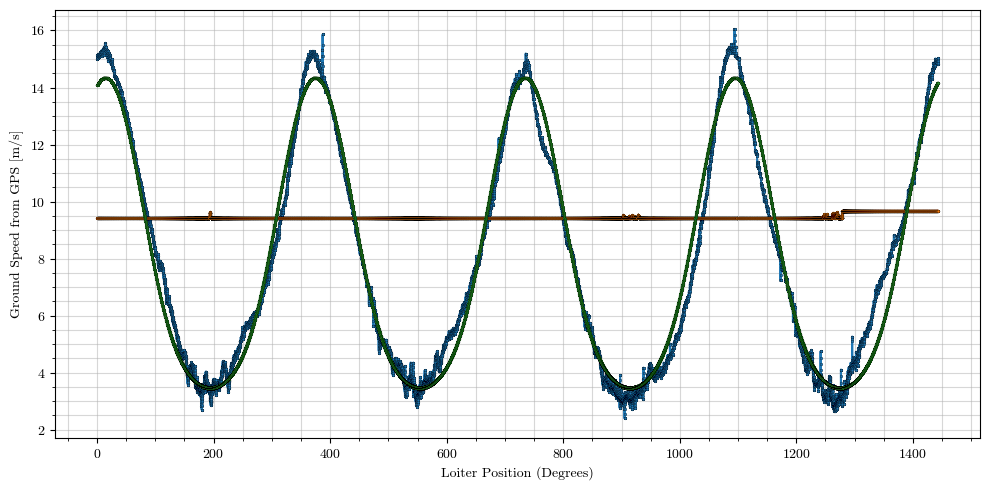

array([5.43937053, 8.90737661, 1.31871634])

In [65]:
theta_complete = np.array([])
segments_complete = pd.DataFrame()

list = np.arange(29,30)

for count, loiter_number in enumerate([30, 31, 32, 33]):
    [thetas, segment_df] = loiter_show(df, loiter_times, loiter_number, show=False)
    thetas = thetas + (count * 360) # Increasing the theta angle by 360 degrees for subsequent loiters
    theta_complete = np.concatenate((theta_complete, thetas), axis=0)
    segments_complete = pd.concat([segments_complete, segment_df])

Vg_actual = np.array(segments_complete.Groundspeed_GPS)
[pop_result, cov_result] = optimize.curve_fit(wind_model, theta_complete, Vg_actual, [5, 10, 0])

groundspeed_fit = wind_model(theta_complete, pop_result[0], pop_result[1], pop_result[2])


plt.figure(figsize=(10,5))
plt.plot(theta_complete, segments_complete.Groundspeed_GPS)
plt.plot(theta_complete, segments_complete.Airspeed_Demanded)
plt.plot(theta_complete, groundspeed_fit)
plt.xlabel("Loiter Position (Degrees)")
plt.ylabel("Ground Speed from GPS [m/s]")
plt.show()
pop_result

14242
14209
13949
14433


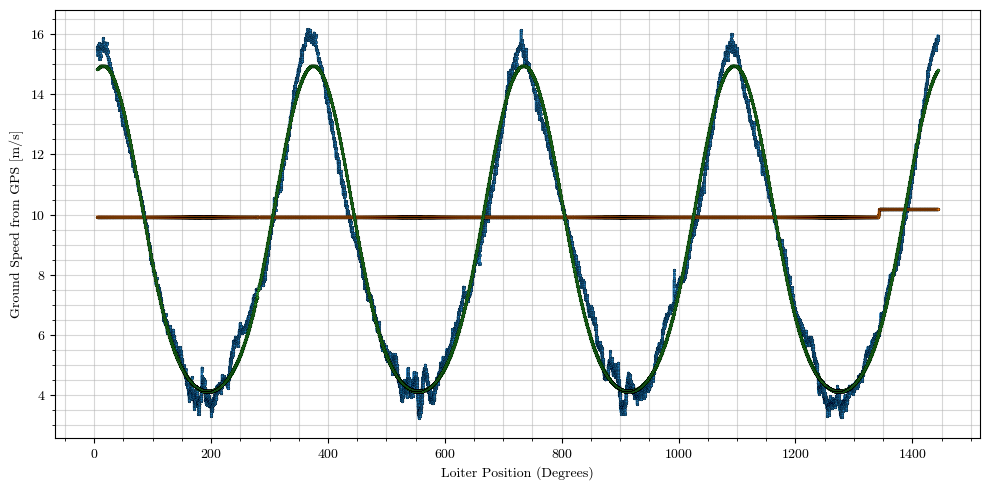

array([5.42143169, 9.53836202, 1.3158438 ])

In [66]:
theta_complete = np.array([])
segments_complete = pd.DataFrame()

list = np.arange(29,30)

for count, loiter_number in enumerate([39, 40, 41, 42]):
    [thetas, segment_df] = loiter_show(df, loiter_times, loiter_number, show=False)
    thetas = thetas + (count * 360) # Increasing the theta angle by 360 degrees for subsequent loiters
    theta_complete = np.concatenate((theta_complete, thetas), axis=0)
    segments_complete = pd.concat([segments_complete, segment_df])

Vg_actual = np.array(segments_complete.Groundspeed_GPS)
[pop_result, cov_result] = optimize.curve_fit(wind_model, theta_complete, Vg_actual, [5, 10, 0])

groundspeed_fit = wind_model(theta_complete, pop_result[0], pop_result[1], pop_result[2])


plt.figure(figsize=(10,5))
plt.plot(theta_complete, segments_complete.Groundspeed_GPS)
plt.plot(theta_complete, segments_complete.Airspeed_Demanded)
plt.plot(theta_complete, groundspeed_fit)
plt.xlabel("Loiter Position (Degrees)")
plt.ylabel("Ground Speed from GPS [m/s]")
plt.show()
pop_result

14433
13795
13559
13453
12892
16199


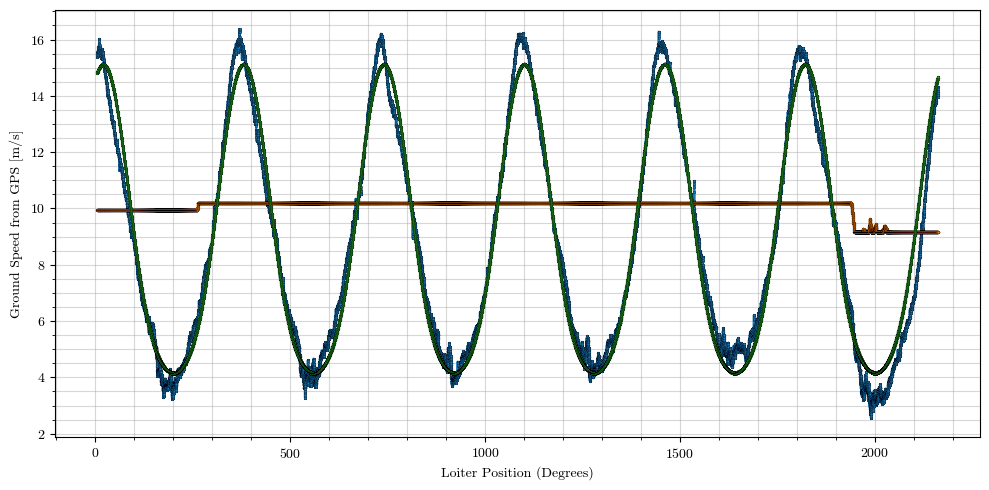

array([5.47875986, 9.63976305, 1.2165481 ])

In [67]:
theta_complete = np.array([])
segments_complete = pd.DataFrame()

list = np.arange(29,30)

for count, loiter_number in enumerate([42, 43, 44, 45, 46, 47]):
    [thetas, segment_df] = loiter_show(df, loiter_times, loiter_number, show=False)
    thetas = thetas + (count * 360) # Increasing the theta angle by 360 degrees for subsequent loiters
    theta_complete = np.concatenate((theta_complete, thetas), axis=0)
    segments_complete = pd.concat([segments_complete, segment_df])

Vg_actual = np.array(segments_complete.Groundspeed_GPS)
[pop_result, cov_result] = optimize.curve_fit(wind_model, theta_complete, Vg_actual, [5, 10, 0])

groundspeed_fit = wind_model(theta_complete, pop_result[0], pop_result[1], pop_result[2])


plt.figure(figsize=(10,5))
plt.plot(theta_complete, segments_complete.Groundspeed_GPS)
plt.plot(theta_complete, segments_complete.Airspeed_Demanded)
plt.plot(theta_complete, groundspeed_fit)
plt.xlabel("Loiter Position (Degrees)")
plt.ylabel("Ground Speed from GPS [m/s]")
plt.show()
pop_result

16199
17485
17703
18104


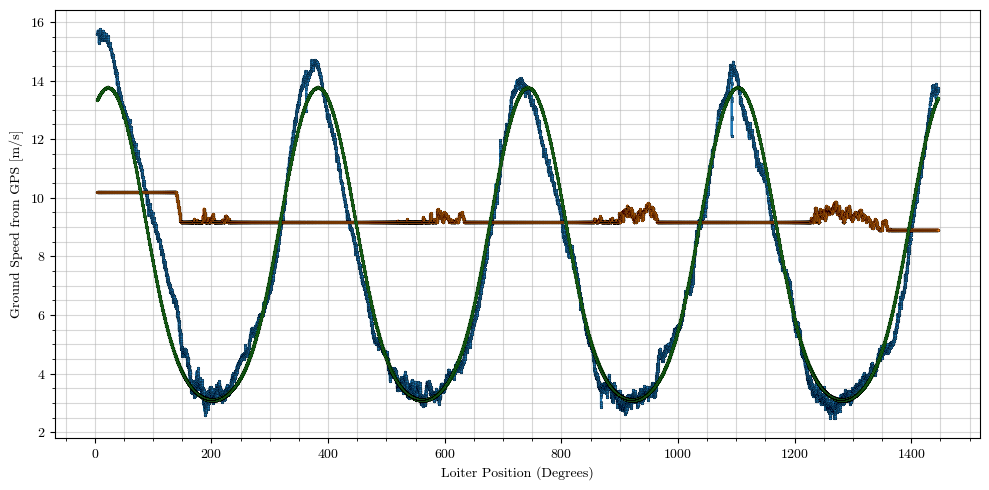

array([5.33246513, 8.43089379, 1.18492626])

In [68]:
theta_complete = np.array([])
segments_complete = pd.DataFrame()

list = np.arange(29,30)

for count, loiter_number in enumerate([47, 48, 49, 50]):
    [thetas, segment_df] = loiter_show(df, loiter_times, loiter_number, show=False)
    thetas = thetas + (count * 360) # Increasing the theta angle by 360 degrees for subsequent loiters
    theta_complete = np.concatenate((theta_complete, thetas), axis=0)
    segments_complete = pd.concat([segments_complete, segment_df])

Vg_actual = np.array(segments_complete.Groundspeed_GPS)
[pop_result, cov_result] = optimize.curve_fit(wind_model, theta_complete, Vg_actual, [5, 10, 0])

groundspeed_fit = wind_model(theta_complete, pop_result[0], pop_result[1], pop_result[2])


plt.figure(figsize=(10,5))
plt.plot(theta_complete, segments_complete.Groundspeed_GPS)
plt.plot(theta_complete, segments_complete.Airspeed_Demanded)
plt.plot(theta_complete, groundspeed_fit)
plt.xlabel("Loiter Position (Degrees)")
plt.ylabel("Ground Speed from GPS [m/s]")
plt.show()
pop_result

18104
18458
19209
18589


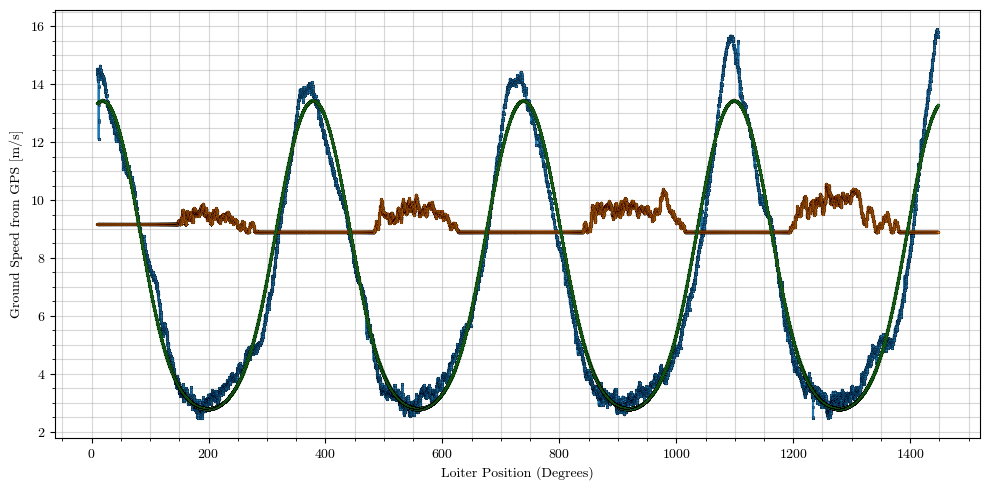

array([5.32369138, 8.11521577, 1.25284658])

In [69]:
theta_complete = np.array([])
segments_complete = pd.DataFrame()

list = np.arange(29,30)

for count, loiter_number in enumerate([50, 51, 52, 53]):
    [thetas, segment_df] = loiter_show(df, loiter_times, loiter_number, show=False)
    thetas = thetas + (count * 360) # Increasing the theta angle by 360 degrees for subsequent loiters
    theta_complete = np.concatenate((theta_complete, thetas), axis=0)
    segments_complete = pd.concat([segments_complete, segment_df])

Vg_actual = np.array(segments_complete.Groundspeed_GPS)
[pop_result, cov_result] = optimize.curve_fit(wind_model, theta_complete, Vg_actual, [5, 10, 0])

groundspeed_fit = wind_model(theta_complete, pop_result[0], pop_result[1], pop_result[2])


plt.figure(figsize=(10,5))
plt.plot(theta_complete, segments_complete.Groundspeed_GPS)
plt.plot(theta_complete, segments_complete.Airspeed_Demanded)
plt.plot(theta_complete, groundspeed_fit)
plt.xlabel("Loiter Position (Degrees)")
plt.ylabel("Ground Speed from GPS [m/s]")
plt.show()
pop_result

12038
10039
9665
10109
10235
9919
11582


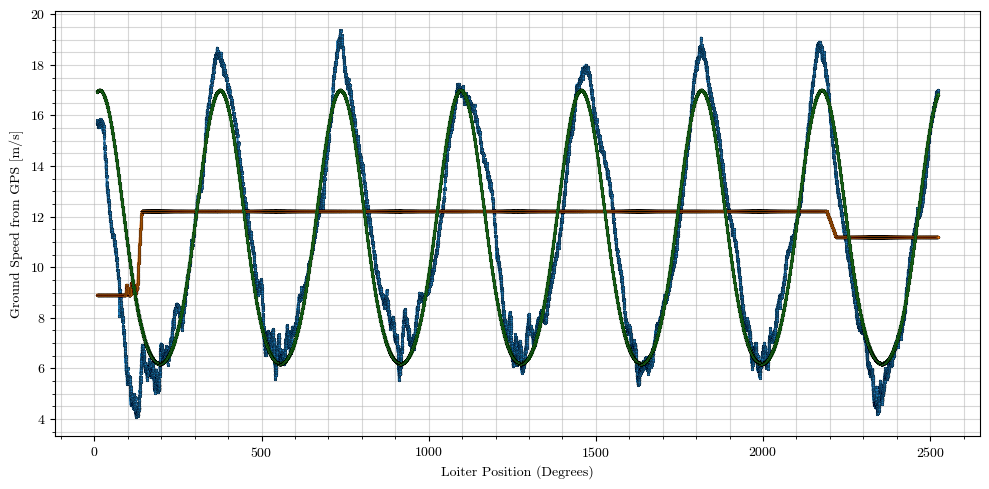

array([ 5.40592834, 11.59515851,  1.30308353])

In [70]:
theta_complete = np.array([])
segments_complete = pd.DataFrame()

list = np.arange(29,30)

for count, loiter_number in enumerate([54, 55, 56, 57, 58, 59, 60]):
    [thetas, segment_df] = loiter_show(df, loiter_times, loiter_number, show=False)
    thetas = thetas + (count * 360) # Increasing the theta angle by 360 degrees for subsequent loiters
    theta_complete = np.concatenate((theta_complete, thetas), axis=0)
    segments_complete = pd.concat([segments_complete, segment_df])

Vg_actual = np.array(segments_complete.Groundspeed_GPS)
[pop_result, cov_result] = optimize.curve_fit(wind_model, theta_complete, Vg_actual, [5, 10, 0])

groundspeed_fit = wind_model(theta_complete, pop_result[0], pop_result[1], pop_result[2])


plt.figure(figsize=(10,5))
plt.plot(theta_complete, segments_complete.Groundspeed_GPS)
plt.plot(theta_complete, segments_complete.Airspeed_Demanded)
plt.plot(theta_complete, groundspeed_fit)
plt.xlabel("Loiter Position (Degrees)")
plt.ylabel("Ground Speed from GPS [m/s]")
plt.show()
pop_result

12038
10039
9665
10109
10235
9919
11582


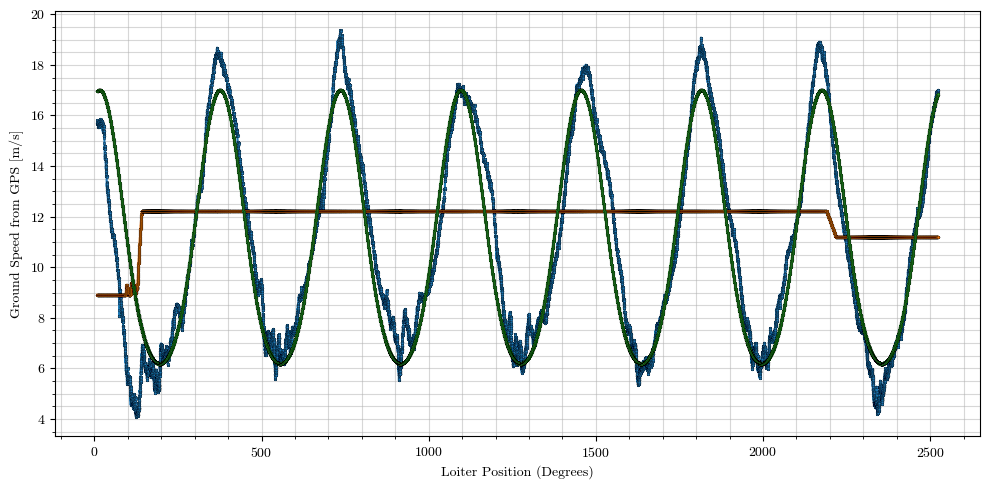

array([ 5.40592834, 11.59515851,  1.30308353])

In [71]:
# Trying Orthogonal Distance Regression Instead since it doesn't seem to capture the peaks well enough
theta_complete = np.array([])
segments_complete = pd.DataFrame()

list = np.arange(29,30)

for count, loiter_number in enumerate([54, 55, 56, 57, 58, 59, 60]):
    [thetas, segment_df] = loiter_show(df, loiter_times, loiter_number, show=False)
    thetas = thetas + (count * 360) # Increasing the theta angle by 360 degrees for subsequent loiters
    theta_complete = np.concatenate((theta_complete, thetas), axis=0)
    segments_complete = pd.concat([segments_complete, segment_df])

Vg_actual = np.array(segments_complete.Groundspeed_GPS)

# Defining curve fitting to the desired loiters
# B = Vw_fit, Vinf_fit, phase_offset
def wind_function(B, theta):
    # Note that theta is given in degrees!
    theta_rad = np.deg2rad(theta)
    Vg = B[1] * np.sin(np.arccos((B[0]/B[1])*np.cos(theta_rad + B[2]))) + B[0]*np.sin(theta_rad + B[2])
    return Vg

wind_model = odr.Model(wind_function)
data = odr.Data(theta_complete, Vg_actual)
myodr = odr.ODR(data, wind_model, beta0=[0, 10, 0])

output = myodr.run()
B = output.beta
B

groundspeed_fit = wind_function(B, theta_complete)


plt.figure(figsize=(10,5))
plt.plot(theta_complete, segments_complete.Groundspeed_GPS)
plt.plot(theta_complete, segments_complete.Airspeed_Demanded)
plt.plot(theta_complete, groundspeed_fit)
plt.xlabel("Loiter Position (Degrees)")
plt.ylabel("Ground Speed from GPS [m/s]")
plt.show()
pop_result